In [2]:
# Load libraries
import os
import random
import numpy as np
import pandas as pd
from typing import Literal
from typing_extensions import TypedDict
from dotenv import load_dotenv, find_dotenv

from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI

from langchain.chains import RetrievalQA
from langchain.document_loaders import TextLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.llms import OpenAI
from langchain.text_splitter import CharacterTextSplitter
from langchain.document_loaders.csv_loader import CSVLoader
from langchain.vectorstores import Chroma
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import Image, display

# import chromadb

## Scene
1. 사용자가 chat 화면에 들어오면, 사용자에 대한 정보 로드
2. 영화 추천해줘
    - 현재 가장 인기있는 영화는 이거에요! (점수 기준 top 5개)
3. 다른 영화 추천해줘
    - 맘에 들지 않으시군요! 혹시 어떤 장르의 영화를 원하시나요?
4. 액션
    - 현재 경민님의 영화 이력을 보아하니 액션에서는 이런 스토리의 영화를 좋아시는군요. 경민님과 성향이 비슷한 다른 분들은 이러한 걸 봤었습니다!

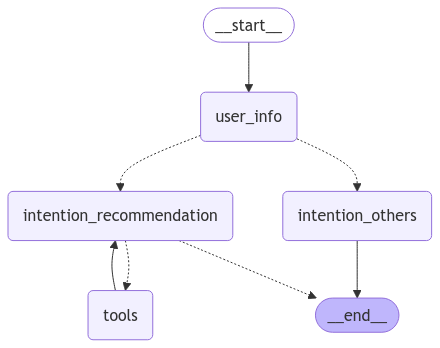

In [57]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode



# State 정의
class State(TypedDict):
    
    # about user
    user_age: int
    user_gender: str
    user_occupation: str
    
    # about query
    input_query: str
    intention: str
    response: str


# Node 정의
def user_info(state):
    age = input("user age: ")
    gender = input("user gender: ")
    occupation = input("user occupation: ")
    print("Checked User Info...")
    
    return {"user_age": age, "user_gender": gender, "user_occupation": occupation}
    
    
def intention_recommendation(state):
    print("Intention Checked: RECOMMENDATION...")
    return {"intention": "recommendation"}


# def node_2_2(state):
#     print("recommendation based on the data")
    
    
def intention_others(state):
    print("Intention Checked: OTHERS...")
    return {"intention": "Others"}


# 
def get_intent(state: State) -> Literal["intention_recommendation", "intention_others"]:

    query = state.get("input_query", "")

    intention_check_system = """
    You are a robot that classifies the user's intent based on their question.
    If the user's question is about asking for a recommendation, respond with 'Recommendation'.
    For all other questions, respond with 'Other'.
    """
    
    intention_check_prompt = ChatPromptTemplate.from_messages(
        [("system", intention_check_system), ("placeholder", "{messages}")]
    )

    intention_check = intention_check_prompt | ChatOpenAI(
        model="gpt-4o", temperature=0
    )

    response = intention_check.invoke(
        {"messages": [("user", query)]}
    )   
    
    if response.content == "Recommendation":
        return "intention_recommendation"

    return "intention_others"


# def recommendataion_baseed_on_data(state):
#     print("recommendation based on the data")
#     loader = CSVLoader(file_path="dummy_data.csv")
#     data = loader.load()
    
#     text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0) 
#     texts = text_splitter.split_documents(data)
    
#     #embeddings model, this can be aa local LLM as well
#     embeddings = OpenAIEmbeddings(openai_api_key=os.environ['OPENAI_API_KEY'])
#     llm = OpenAI(openai_api_key=os.environ['OPENAI_API_KEY'])

#     #Vector DB
#     docsearch = Chroma.from_documents(texts, embeddings)
    
#     #Retriever
#     qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=docsearch.as_retriever())
#     response = qa.run(state["input_query"]).split(".")
    
#     return {"response": ' '.join(response)}
    

# tools
# 추천이라고 판단되면 tools을 이용하여 추천
def recommenation_based_on_user_info(age: int,
                                     gender: str,
                                     accupation: str) -> list:
    """
    사용자 개인정보를 활용하여 영화 추천
    """
    # movielens 데이터 로드
    df = pd.read_csv('./ml_merged.csv')
    df.drop(["Unnamed: 0"], axis=1, inplace=True)

    # accupation = "student"
    # age = 25
    # gender = "F"
    df = df.loc[(df.occupation==accupation) & (df['age'].between(age-5, age+5)) & (df.gender == gender)]
    df = df.sort_values(by = "rating", ascending=False)
    
    movie_titles = df.movie_title.value_counts()[:5].index
    
    return list(movie_titles)
    

def recommendation_most_popular() -> list:
    """
    가장 많이 본 거 
    """
    # movielens 데이터 로드
    df = pd.read_csv('./ml_merged.csv')
    df.drop(["Unnamed: 0"], axis=1, inplace=True)
    movie_titles = df.movie_title.value_counts()[:5].index
    
    return list(movie_titles)

    
def get_movie_info(movies):
    """
    추천된 영화에 대한 정보 가져오기
    """
    
    return "Movie is about....."
    ## 크롤링해서 영화 내용 요약, 스토리라인 같은 거 가져오고 싶음
    

tools = [recommenation_based_on_user_info, recommendation_most_popular, get_movie_info]
# LLM 모델 정의
llm = ChatOpenAI(model="gpt-4o")    
llm_with_tools = llm.bind_tools(tools)


# Build graph
builder = StateGraph(State)
builder.add_node("user_info", user_info)
builder.add_node("intention_recommendation", intention_recommendation)
## tools 추가필요
builder.add_node("tools", ToolNode(tools))
builder.add_node("intention_others", intention_others)

# Logic
builder.add_edge(START, "user_info")
builder.add_conditional_edges("user_info", get_intent)
builder.add_conditional_edges("intention_recommendation", tools_condition)
builder.add_edge("tools", "intention_recommendation")
# builder.add_edge("intention_recommendation", END)
builder.add_edge("intention_others", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [64]:
# Input
initial_input = {"user_age": 25, "user_occupation": "student", "user_gender":"F", 
                 "messages": "recommend a movie"}
    # accupation = "student"
    # age = 25
    # gender = "F"
# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1]

KeyError: 'messages'

In [6]:
# Thread
thread = {"configurable": {"thread_id": "1"}}
graph.invoke({"input_query":"앞으로의 트럼프의 행보는 어떻게 될까"})

Checked User Info...
Intention Checked: OTHERS...


{'user_age': '33',
 'user_gender': 'F',
 'user_occupation': 'student',
 'input_query': '앞으로의 트럼프의 행보는 어떻게 될까',
 'intention': 'Others'}

In [7]:
graph.get_state

<bound method Pregel.get_state of <langgraph.graph.state.CompiledStateGraph object at 0x0000012BA0F6A290>>

In [19]:
output = graph.invoke({"input_query":"Suggest 2 articles to user-id 78 using given data which it has not seen.\
Follow this approach 1: Find similar Users and 2: sugest new articles from similar users.\
Also give a reason for suggestion"})

---Node 1---
---recommend---
recommendation based on the data


In [20]:
output

{'input_query': 'Suggest 2 articles to user-id 78 using given data which it has not seen.Follow this approach 1: Find similar Users and 2: sugest new articles from similar users.Also give a reason for suggestion',
 'intention': '추천',
 'response': '\n1  User 78 has not seen any articles in the dataset, so there are no similar users to recommend articles from \n2  Based on the given data, I would recommend the following two articles to user 78:\n- "The Top 10 Benefits of Meditation" (item_id 14): This article has been seen by users 5 and 6, who have also seen a lot of other articles related to self-care and mindfulness  Since user 78 has not seen any articles, this could be a good starting point for them to explore this topic \n- "How to Start a Daily Journal Practice" (item_id 12): This article has been seen by user 12, who has also seen a lot of other articles related to self-improvement and personal growth  Since user 78 has not seen any articles, this could be a good opportunity for 

In [21]:
print(output['response'])


1  User 78 has not seen any articles in the dataset, so there are no similar users to recommend articles from 
2  Based on the given data, I would recommend the following two articles to user 78:
- "The Top 10 Benefits of Meditation" (item_id 14): This article has been seen by users 5 and 6, who have also seen a lot of other articles related to self-care and mindfulness  Since user 78 has not seen any articles, this could be a good starting point for them to explore this topic 
- "How to Start a Daily Journal Practice" (item_id 12): This article has been seen by user 12, who has also seen a lot of other articles related to self-improvement and personal growth  Since user 78 has not seen any articles, this could be a good opportunity for them to discover new ways to work on themselves 


In [24]:
graph.invoke({"input_query": "user-id 78번에게 주어진 데이터를 사용하여 아직 보지 않은 기사 2개를 추천하세요. \
    다음 접근 방식을 따르세요: 1. 유사한 사용자를 찾고 \
        2. 유사한 사용자로부터 새로운 기사를 추천하세요. 또한 추천 이유를 제시하세요."})



---Node 1---
---recommend---
recommendation based on the data


{'input_query': 'user-id 78번게 주어진 데이터를 사용하여 아직 보지 않은 기사 2개를 추천하세요.     다음 접근 방식을 따르세요: 1. 유사한 사용자를 찾고         2. 유사한 사용자로부터 새로운 기사를 추천하세요. 또한 추천 이유를 제시하세요.',
 'intention': '추천',
 'response': " I'm sorry, I don't have enough information to answer this question  The given context does not provide any information about other users or their preferences, so it is not possible to find similar users or recommend new articles based on that  "}

In [ ]:
# tool_node..?
def text_spliter(data):
    """
    그냥 텍스트 splitter 넣어봄
    """
    text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
    texts = text_splitter.split_documents(data)

    return texts

def embedding(texts):
    #embeddings model, this can be aa local LLM as well
    embeddings = OpenAIEmbeddings(openai_api_key=os.environ['OPENAI_API_KEY'])
    llm = OpenAI(openai_api_key=os.environ['OPENAI_API_KEY'])

    #Vector DB
    docsearch = Chroma.from_documents(texts, embeddings)
    return docsearch






